In [123]:
import cv2
import numpy as np
import pywt
from matplotlib import pyplot as plt


In [69]:
lena = cv2.imread('./Images/Lena.bmp',cv2.IMREAD_GRAYSCALE)
lena = np.array(lena)

mona_lisa = cv2.imread('./Images/mona lisa.jpg',cv2.IMREAD_GRAYSCALE)
mona_lisa = np.array(mona_lisa)


In [74]:
def subplot(rows_count, column_count, images, titles):
    for i in range(len(images)):
        plt.subplot(rows_count, column_count, i+1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray')


In [38]:
def plot_image(image, title=''):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.show()


5. Wavelet  
5.1. Pyramid

5.1.1. For the “Mona Lisa” image, build a 5 level Gaussian pyramid and display it in a format. Also, implement and display a Laplacian (difference of Gaussian (DoG)) pyramid.

In [52]:
def get_down_gussian_pyramid(image, NOLevels):

    layer = image.copy()
    pyramid = []
    for i in range(NOLevels):

        pyramid.append(layer)
        # pyrDown() decreases the size to half.
        layer = cv2.pyrDown(layer)

    return pyramid


def get_up_gussian_pyramid(image, NOLevels):
    layer = image.copy()
    pyramid = []

    for i in range(NOLevels):

        # pyrDown() decreases the size to half.
        layer = cv2.pyrUp(layer)
        pyramid.append(layer)

    return pyramid


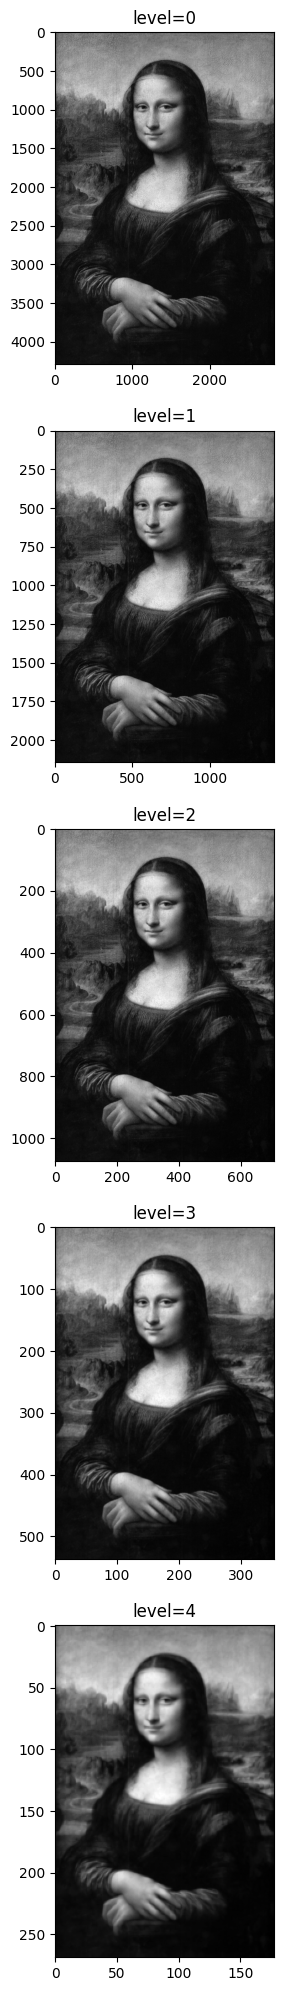

In [53]:
number_of_pyramid_levels = 5
pyramid = get_down_gussian_pyramid(mona_lisa, number_of_pyramid_levels)

titles = []
for i in range(number_of_pyramid_levels):
    titles.append('level={}'.format(i))

plt.figure(figsize=(30, 25))
subplot(number_of_pyramid_levels, 1, pyramid, titles)


In [76]:
def get_laplacian_pyramid(image, NOLevels):
    img = image.copy()

    # Create the Gaussian pyramid
    gaussian_pyramid = get_down_gussian_pyramid(img, NOLevels)

    # Create the Laplacian pyramid
    last_level_of_gaussian = gaussian_pyramid[NOLevels - 1]
    laplacian_pyramid = [last_level_of_gaussian]
    for i in range(NOLevels - 1, 0, -1):
        expanded_img = cv2.pyrUp(gaussian_pyramid[i])
        img = gaussian_pyramid[i-1].copy()

        # check if number of rows are not equal
        if img.shape[0] != expanded_img.shape[0]:
            img = cv2.copyMakeBorder(
                img, 0, 1, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        # check if number of columns are not equal
        if img.shape[1] != expanded_img.shape[1]:
            img = cv2.copyMakeBorder(
                img, 0, 0, 0, 1, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        laplacian = cv2.subtract(img, expanded_img)
        laplacian_pyramid.append(laplacian)
    
    return laplacian_pyramid


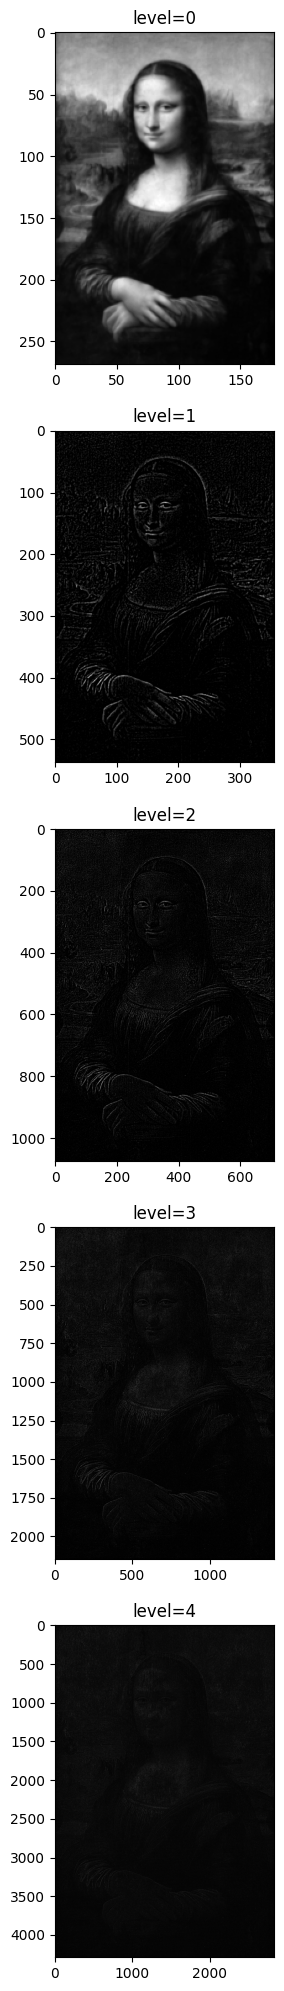

In [77]:
number_of_pyramid_levels = 5
pyramid = get_laplacian_pyramid(mona_lisa, number_of_pyramid_levels)

titles = []
for i in range(number_of_pyramid_levels):
    titles.append('level={}'.format(i))

plt.figure(figsize=(30, 25))
subplot(number_of_pyramid_levels, 1, pyramid, titles)


5.1.2. Describe how separability and cascading can help to speed up Gaussian smoothing and design a fast algorithm for computing a 3-step gaussian pyramid (filtered with σ, √2σ, 2σ) of a 2D image using pseudo-code.

You can find a complete description for this problem in report file which is available in VU.  
but here I just show you the pseudo-code.

Input: image, levels, sigma  
Output: pyramid  

pyramid = [image]  
for i = 1 to levels:  
    blurred_x = separableGaussianBlur(image, sigma)  
    blurred_xy = separableGaussianBlur(blurred_x, sigma)  
    image = downSample(blurred_xy)  
    pyramid.append(image)  
    sigma = sqrt(2) * sigma  

return pyramid  

function separableGaussianBlur(image, sigma)  
    kernel = create1DGaussianKernel(sigma)  
    blurred_x = convolve(image, kernel)  
    blurred_xy = convolve(blurred_x, transpose(kernel))  
    return blurred_xy  

function downSample(image)  
    return image resized by half  


5.1.3. Given an image of size 𝑁×𝑁, where 𝑁=2𝐽, what is the maximum number of levels you can have in an approximation pyramid representation? (The maximum level is reached when the coarsest level has only 1 pixel). What is the total number of pixels in the pyramid (i.e. including pixels at all pyramid levels)? How does this number compare with the original number of pixels in the image? Since this number is larger than the original pixel number, what are some of the benefits of using the approximation pyramid? (give some examples). Repeat the step for the prediction residual pyramid. Display and discuss the results.

You can find a complete description for this problem in report file which is available in VU.  

5.1.4. For the grayscale Lena image, manually compute a 3-level approximation pyramid and corresponding prediction residual pyramid. Use 2x2 averaging for the approximation and use pixel replication for the interpolation filters.

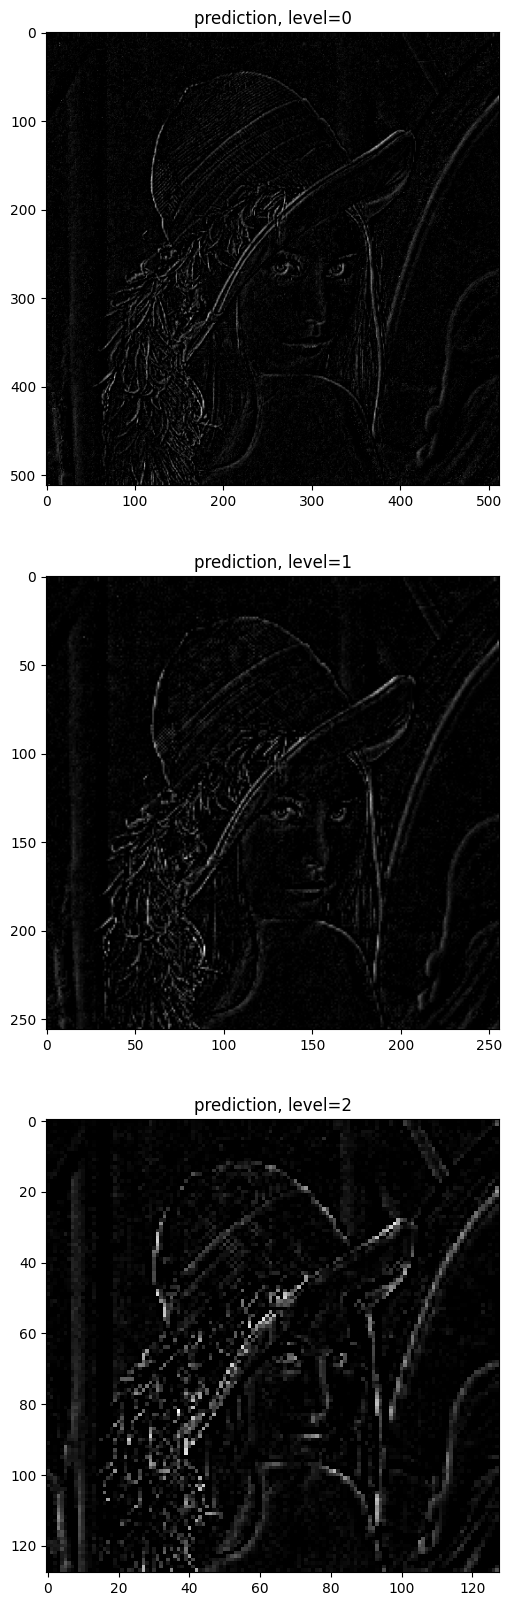

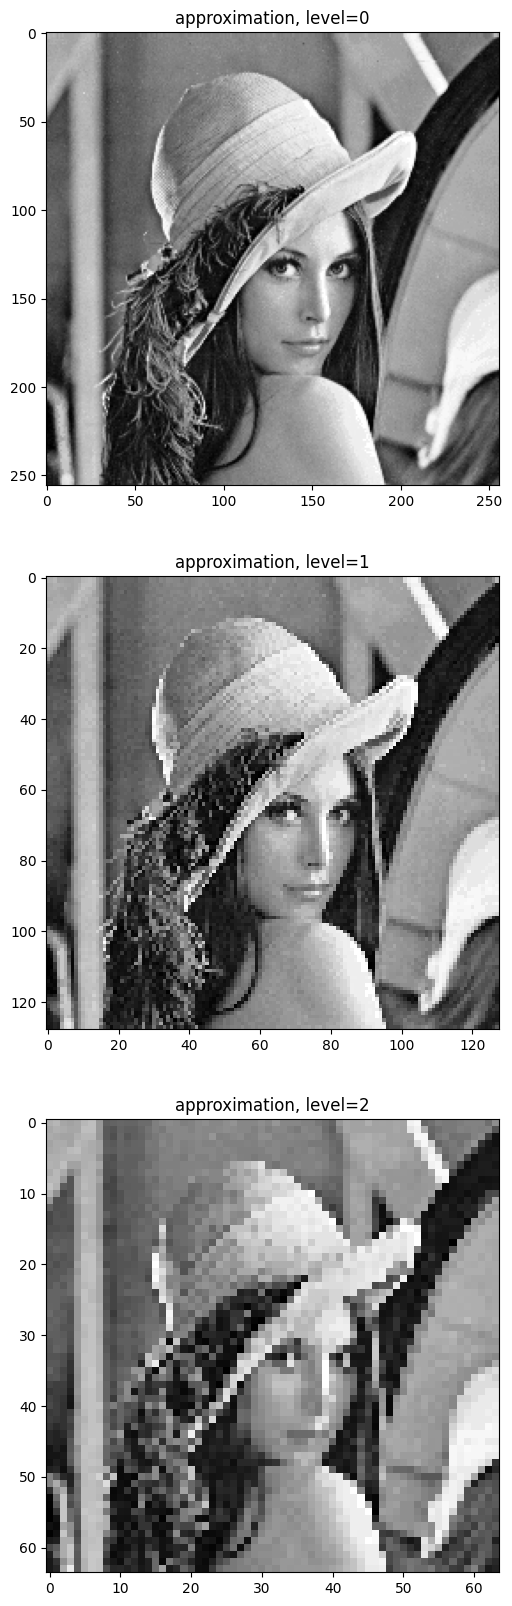

In [110]:
img = lena.copy()

# Create a list to hold the pyramids
approx_pyramid = []
pred_residual_pyramid = []

# Add the original image to the list
# approx_pyramid.append(img)
# pred_residual_pyramid.append(img)

# Set the number of levels
levels = 3

# Create the pyramids
for i in range(levels):
    # Down-sample the current image using 2x2 averaging
    current_img = img[::2, ::2]
    approx_pyramid.append(current_img)
    
    # Up-sample the previous level of the approximation pyramid using pixel replication
    upsampled_img = cv2.resize(
        approx_pyramid[i], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Predict the current image by subtracting the upsampled version of the previous level
    prediction = cv2.subtract(img, upsampled_img)

    # Add the prediction to the current level of the approximation pyramid
    pred_residual_pyramid.append(prediction)

    img = current_img.copy()


titles = []
for i in range(levels+1):
    titles.append('prediction, level={}'.format(i))

plt.figure(figsize=(20, 20))
subplot(levels, 1, pred_residual_pyramid, titles)

titles = []
for i in range(levels+1):
    titles.append('approximation, level={}'.format(i))

plt.figure(figsize=(20, 20))
subplot(levels, 1, approx_pyramid, titles)



5.1.5. For the grayscale Lena Image, compute the wavelet transform (with 3-level) using the Haar analysis filters. Comment on the differences between the pyramids generated in Prob. 5.1.4 with the ones generated here.

In [141]:
def get_wavelet_pyramid(image, NOLevels):
    pyramid = []
    for i in range(NOLevels):
        # Perform the wavelet transform
        coeffs = pywt.dwt2(image, 'haar')

        # The output is a tuple of (cA, (cHL, cLH, cHH))
        # cA is the approximation coefficients
        # cHL is the horizontal detail coefficients
        # cLH is the vertical detail coefficients
        # cHH is the diagonal detail coefficients

        pyramid.append(coeffs)
        image = coeffs[0].copy()
        
    return pyramid
  

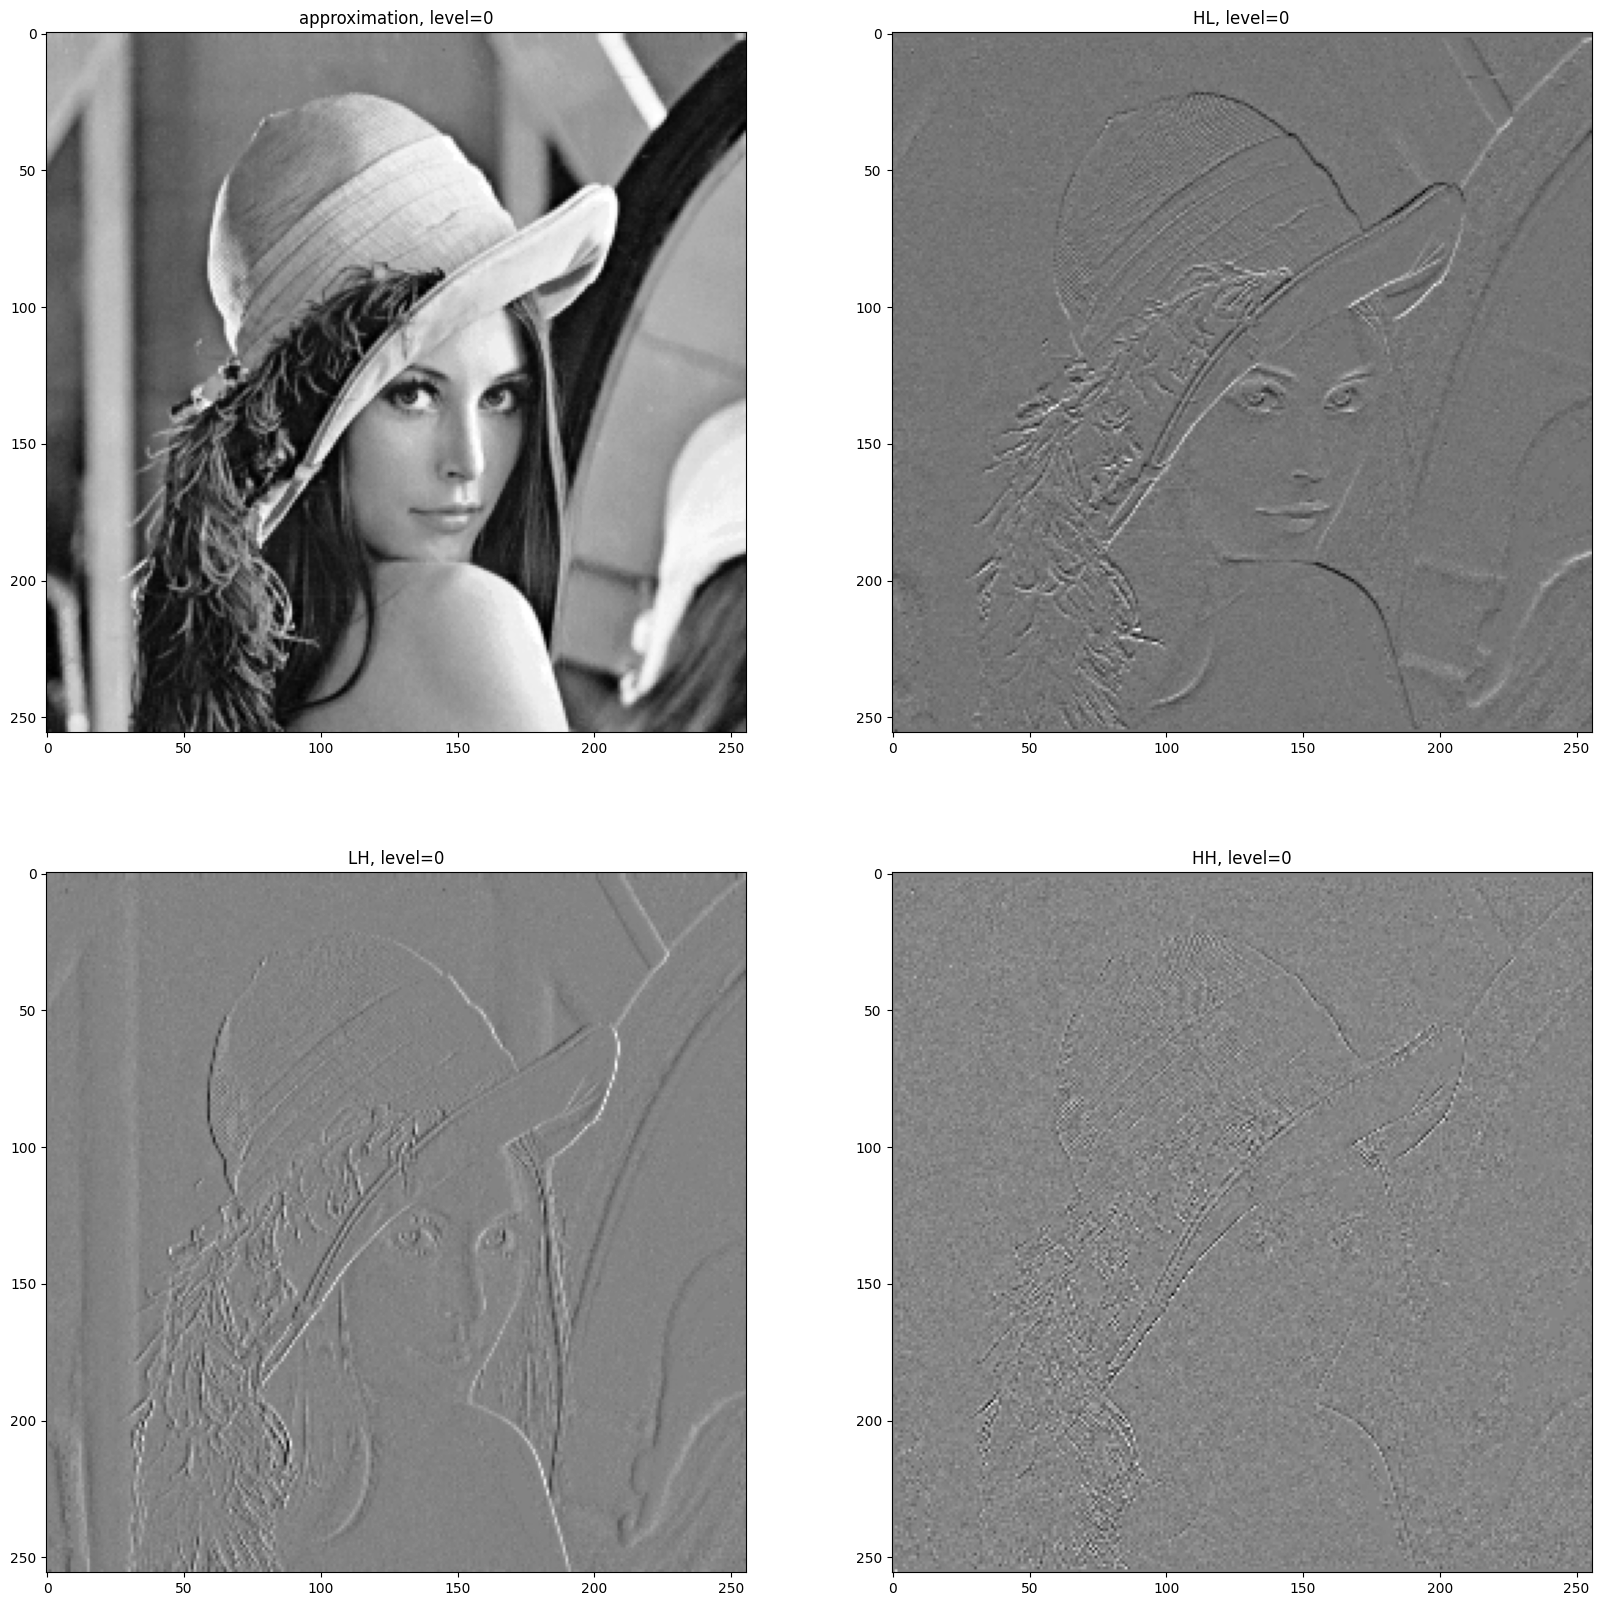

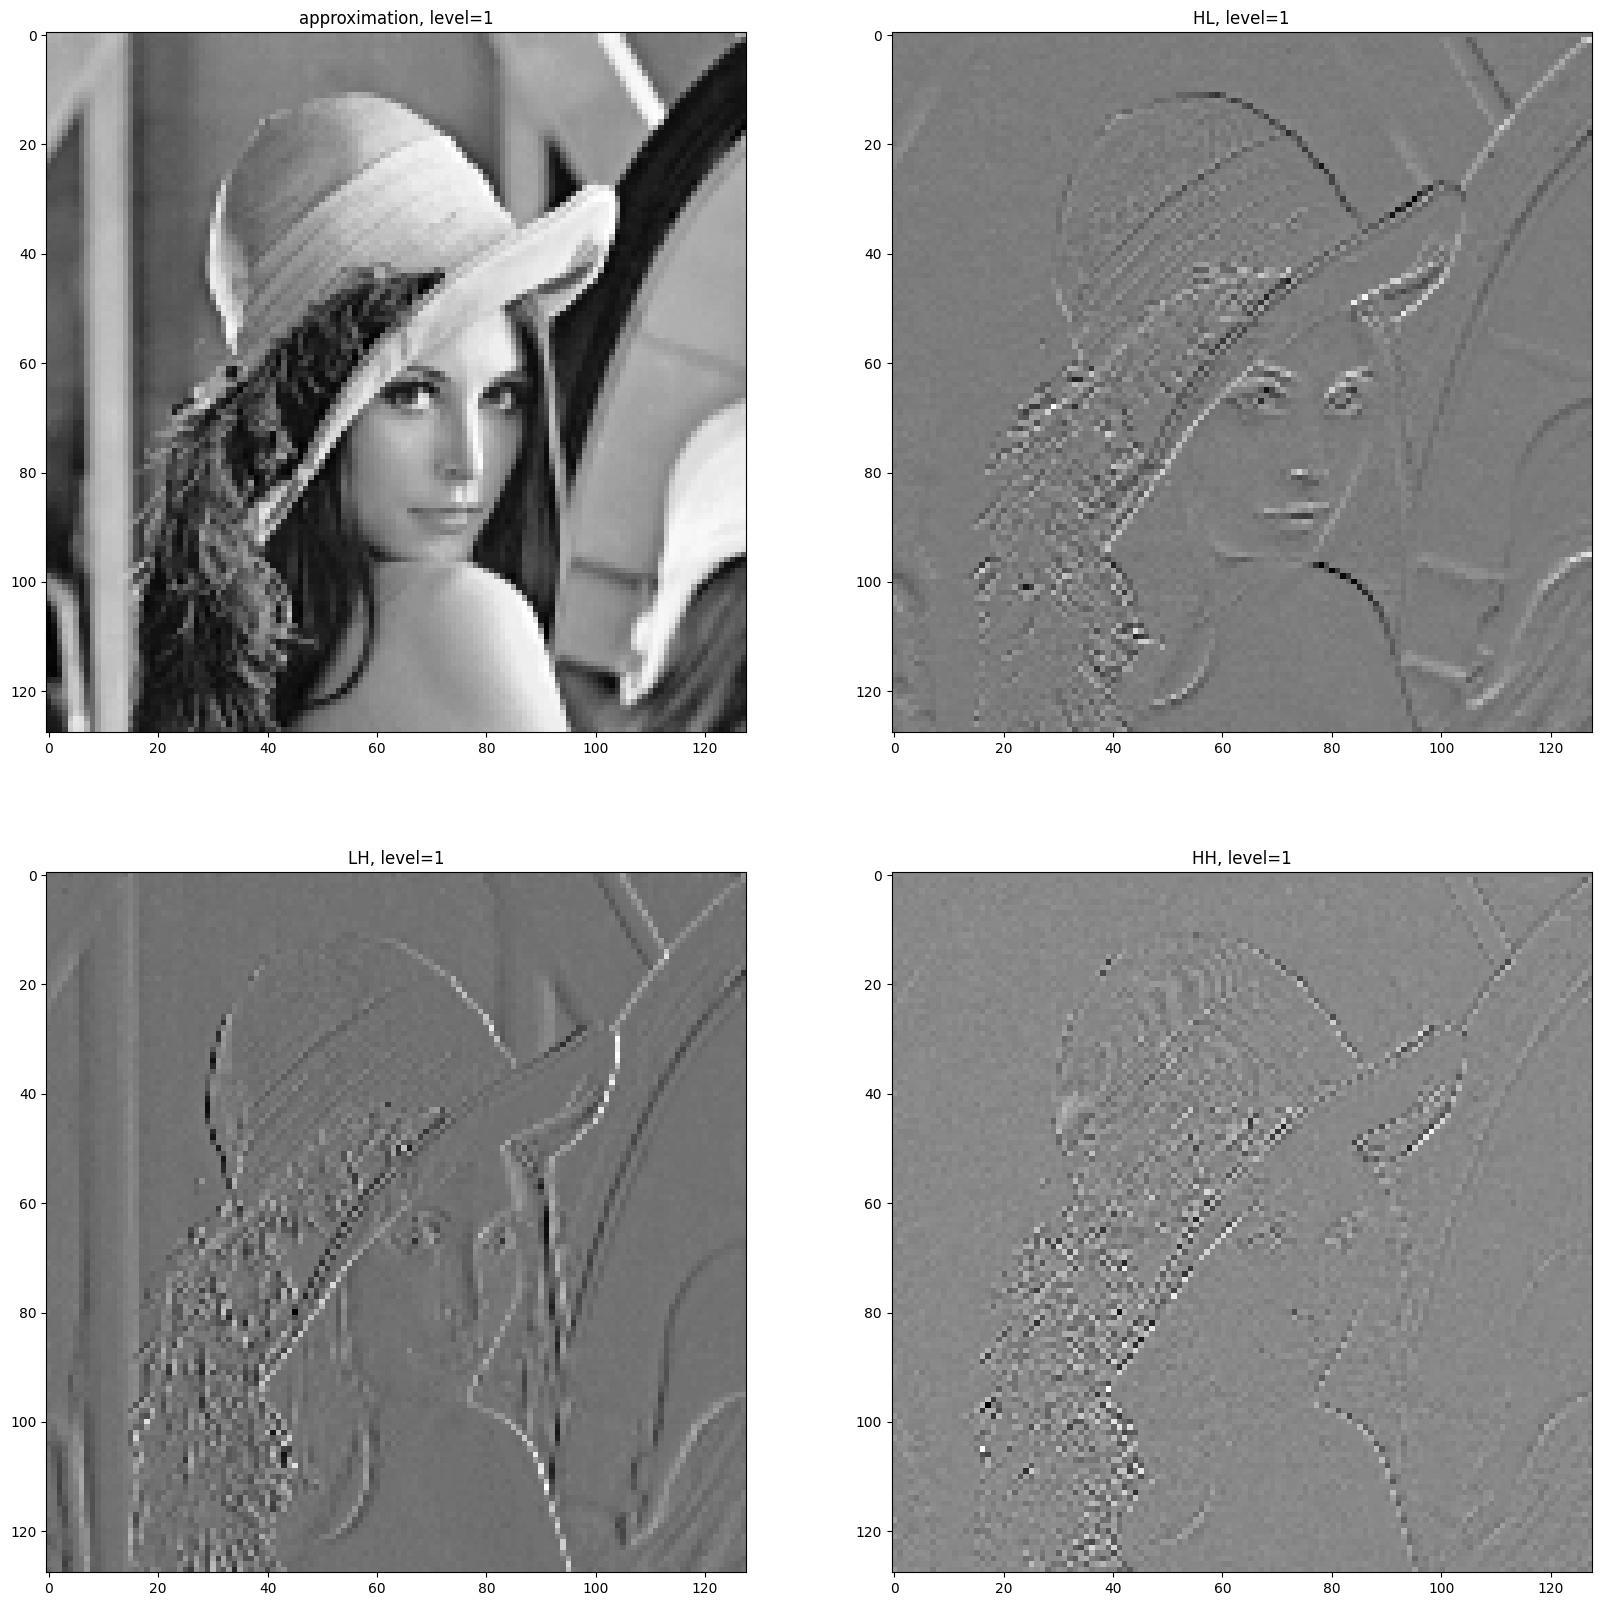

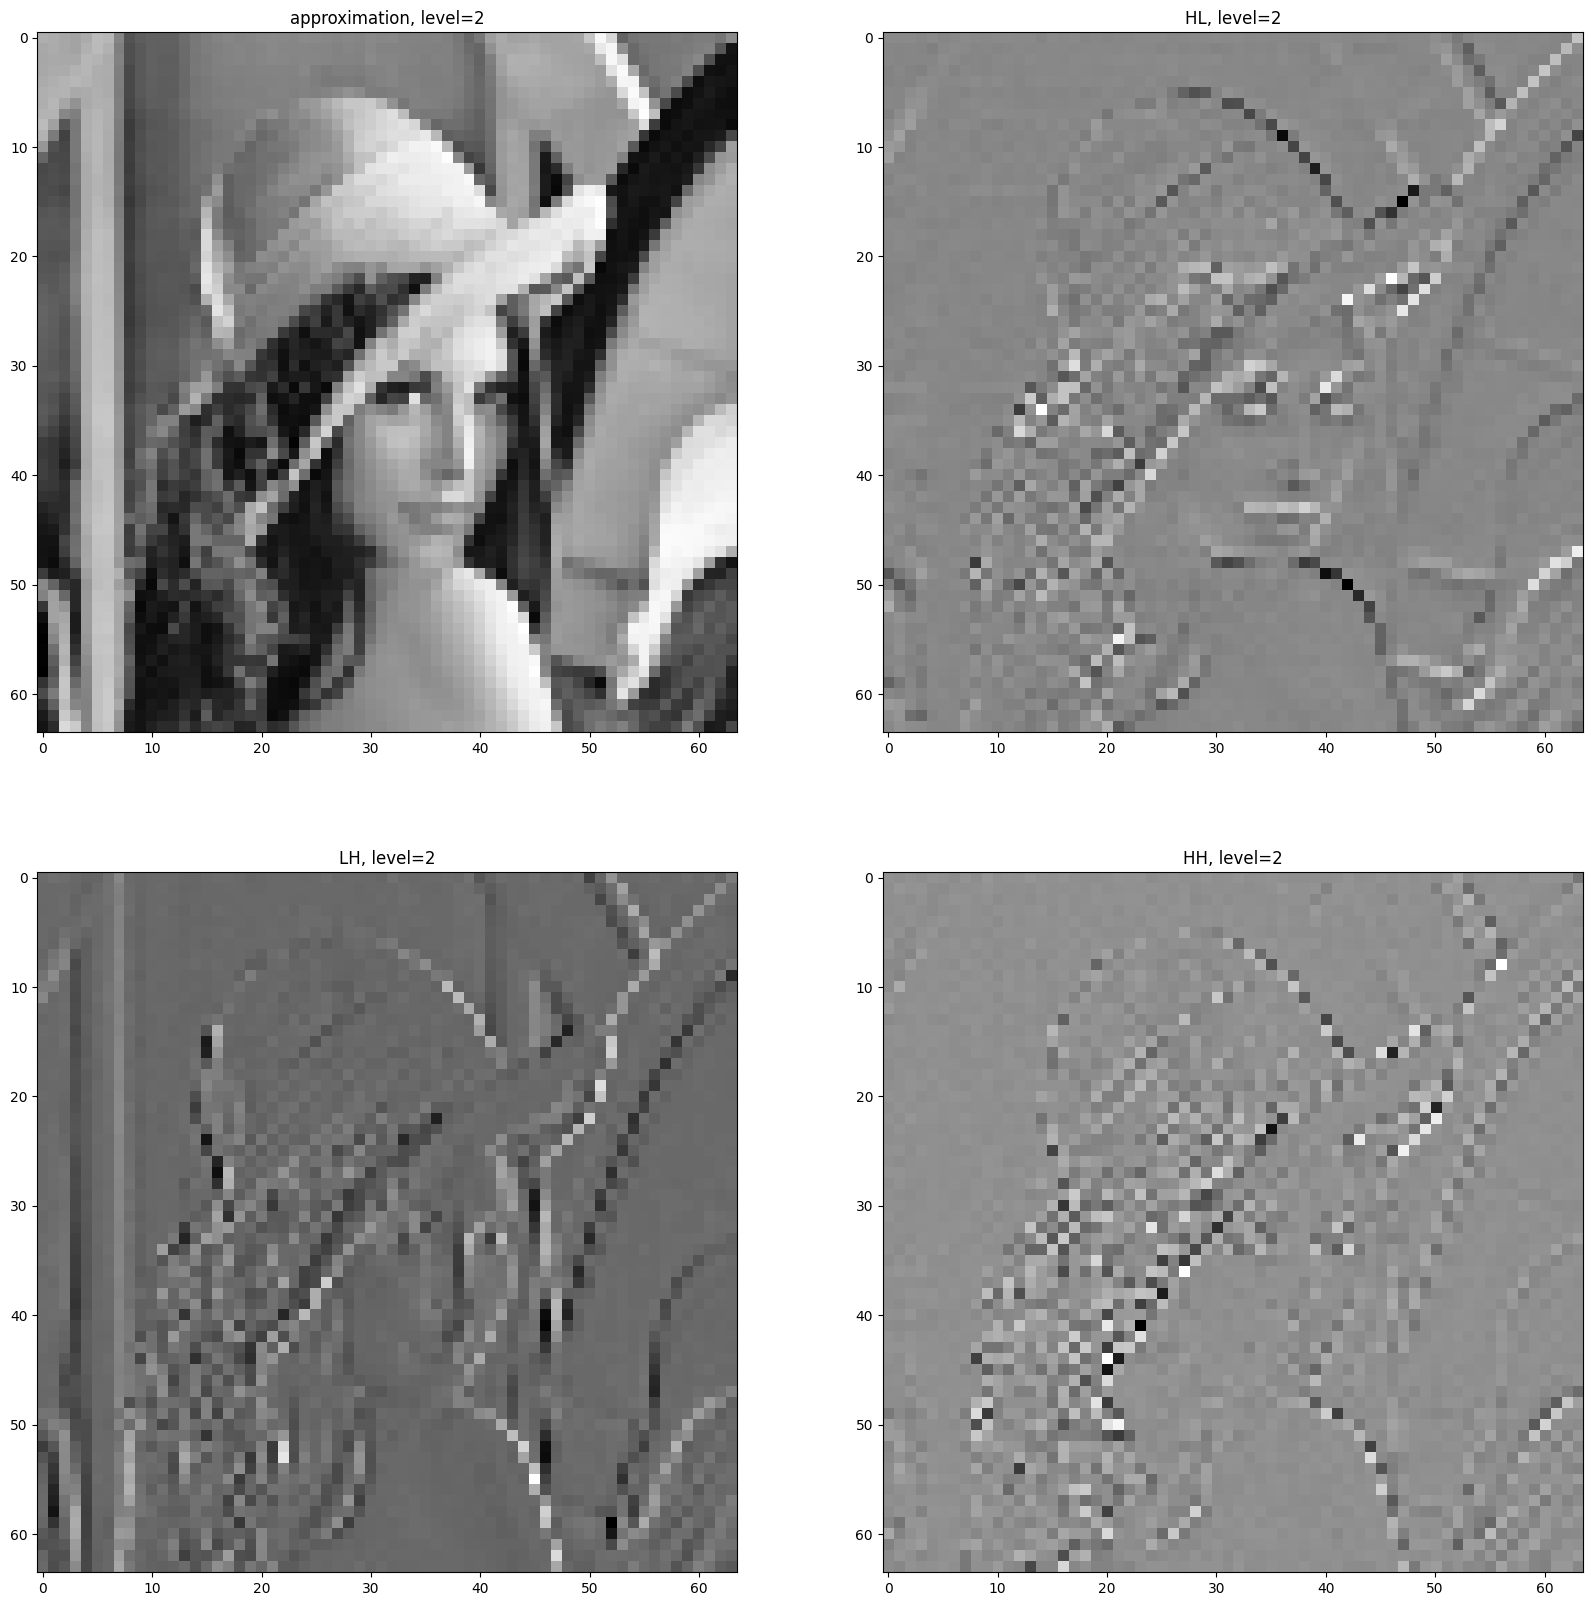

In [149]:
number_of_pyramid_levels = 3
pyramid = get_wavelet_pyramid(lena, number_of_pyramid_levels)

for i in range(number_of_pyramid_levels):
    (approx, (HL, LH, HH)) = pyramid[i]
    coeffs = [approx, HL, LH, HH]
    titles = [f'approximation, level={i}',
              f'HL, level={i}', f'LH, level={i}', f'HH, level={i}']

    plt.figure(figsize=(20, 20))
    subplot(2, 2, coeffs, titles)
